## Read data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.regressor import PredictionError, ResidualsPlot
import warnings 
warnings.filterwarnings('ignore')

In [2]:
covid = pd.read_excel('Covid19_SourceFile.xlsx')
icd = pd.read_excel('ICD10_Dx_TaxonomyTree.xlsx', sheet_name = 'ICD10TaxonomyTree')

In [3]:
covid.head()

,Patient ID,AgeCode,SexCode,DX0,DX1,DX2,DX3,DX4,DX5,DX6,...,DX12,DX13,DX14,DX15,DX16,DX17,DX18,DX19,DX20,Mortality (1= death)
0,1,13,2.0,U071,L600,J45909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,11,2.0,U071,Z86010,K5730,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,12,2.0,U071,Z1211,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,10,1.0,U071,Z1211,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,13,2.0,U071,Z1211,I4901,Z95810,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Map Sex 

In [4]:
covid['SexCode'] = covid['SexCode'].fillna(0)
covid['SexCode'] = covid['SexCode'].astype('i')
sex_map = {1:1, 2:0, 0:0}
covid['SexCode'] = covid['SexCode'].map(sex_map)
covid.drop('DX0', axis = 1, inplace = True)

In [5]:
covid['SexCode'].value_counts()

0    202231
1    168402
Name: SexCode, dtype: int64

## Map age group 

In [6]:
age_groups = pd.read_excel('ICD10_Dx_TaxonomyTree.xlsx', sheet_name = 'Gender_Age', skiprows=1).iloc[:,[3,5]].head(15).set_index('Age').to_dict()['Map to ']
covid['AgeCode'] = covid['AgeCode'].map(age_groups)
covid['AgeCode'].unique()

array(['Age_70_74', 'Age_60_69', 'Age_50_59', 'Age_75_99', 'Age_40_49',
       'Age_18_39', 'RefUnder18'], dtype=object)

In [7]:
covid.groupby('AgeCode').agg({'Mortality (1= death)':'mean'})['Mortality (1= death)']*100

AgeCode
Age_18_39      0.779757
Age_40_49      2.423940
Age_50_59      4.739856
Age_60_69      7.714590
Age_70_74     11.396117
Age_75_99     19.499287
RefUnder18     0.518634
Name: Mortality (1= death), dtype: float64

In [8]:
temp = list(covid.groupby('AgeCode').agg({'Mortality (1= death)':'mean'})['Mortality (1= death)'] * 100)
temp_last = temp.pop()
temp.insert(0,temp_last)
temp

[0.518633608333151,
 0.7797568216013989,
 2.423940149625935,
 4.739855789622508,
 7.71458984068264,
 11.396117306897976,
 19.499286762729735]

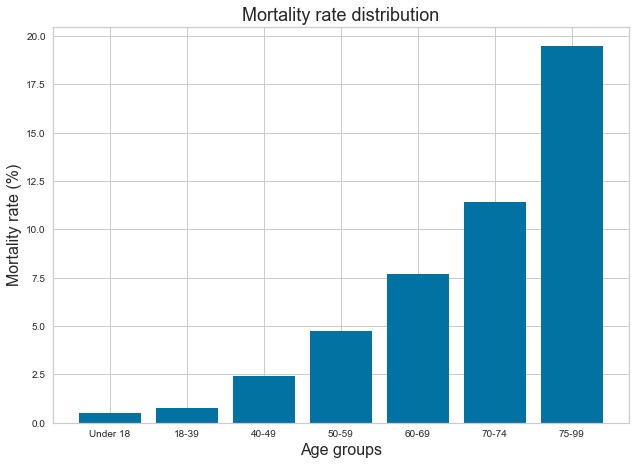

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Under 18', '18-39', '40-49', '50-59', '60-69','70-74','75-99']
Mortality = temp
ax.bar(langs,Mortality)
plt.xlabel('Age groups', fontsize = 16)
plt.ylabel('Mortality rate (%)', fontsize = 16)
plt.title('Mortality rate distribution', fontsize = 18)
plt.show()

## Map disease

In [10]:
icd_map = dict(zip(icd['ICD10 Dx Code'], icd['DGL_3_Extend']))
for column in covid.columns[3:-1]:
    covid[column] = covid[column].map(icd_map)

In [11]:
df = pd.get_dummies(covid)

In [12]:
for i in icd['DGL_3_Extend'].unique():
    df[i] = df[df.columns[df.columns.str.contains(i)]].sum(axis = 1)
    df[i] = df[i].astype('i')

In [13]:
df.head()

,Patient ID,SexCode,Mortality (1= death),AgeCode_Age_18_39,AgeCode_Age_40_49,AgeCode_Age_50_59,AgeCode_Age_60_69,AgeCode_Age_70_74,AgeCode_Age_75_99,AgeCode_RefUnder18,...,UROLG_GEN_Kidney,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status_A,UROLG_GEN_Status_B,UROLG_GEN_Status2
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_final = pd.concat([df.iloc[:,0:10],df.iloc[:,2880:]], axis = 1)
df_final.columns = df_final.columns.str.replace('AgeCode_', '')

In [15]:
df_final.to_csv('covid_final.csv', index = False)

## Modelling

In [16]:
df_final = pd.read_csv('covid_final.csv')
df_final.rename({'Mortality (1= death)':'Mortality'}, axis = 1, inplace = True)
df_final.head()

,Patient ID,SexCode,Mortality,Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,RefUnder18,...,UROLG_GEN_Kidney,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status_A,UROLG_GEN_Status_B,UROLG_GEN_Status2
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = pd.concat([df_final.iloc[:,1],df_final.iloc[:,3:]], axis = 1)
y = df_final.iloc[:,2]

Undersample = RandomUnderSampler(sampling_strategy = 1)
X_under, y_under = Undersample.fit_resample(X, y)

In [18]:
y_under.value_counts()

1    21270
0    21270
Name: Mortality, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state = 42)

## Linear regression

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print('Accuracy score on testing set: ', round(lr.score(X_test, y_test), 2))
print('Accuracy score on original data: ', round(lr.score(X, y), 2))

Accuracy score on testing set:  -52240037547518.84
Accuracy score on original data:  -99563575878118.45


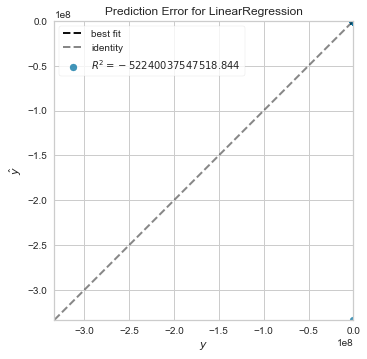

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [21]:
visualizer = PredictionError(lr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

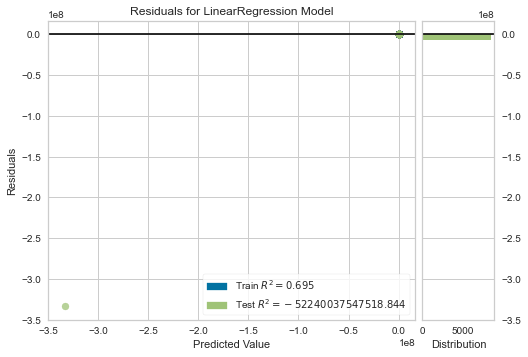

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [22]:
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

## Lasso

In [23]:
lasso = Lasso(alpha = 0.001, random_state = 42)
lasso.fit(X_train, y_train)

print('Accuracy score on testing set: ', round(lasso.score(X_test, y_test), 2))

la = lasso.predict(X)
la_list = []
for i in la:
    if i >1:
        i = 1
    if i<0:
        i = 0
    i = np.round(i)
    la_list.append(i)
la_cm = confusion_matrix(y, la_list)
print('Confusion matrix')
print(la_cm)

Accuracy score on testing set:  0.68
Confusion matrix
[[331116  18247]
 [  1446  19824]]


Text(0.5, 1.0, 'Confusion_matrix, lasso')

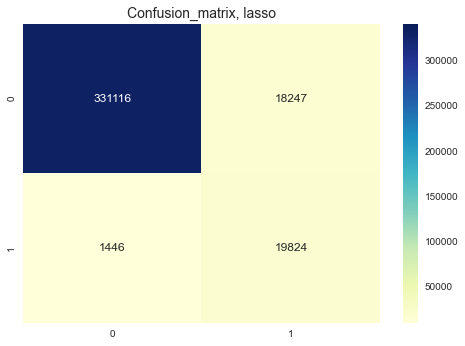

In [24]:
sns.heatmap(la_cm, vmin=10000, vmax=340000, annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Confusion_matrix, lasso', fontsize = 14)

In [25]:
tn, fp, fn, tp = la_cm.ravel()
recall_lasso = tp / (tp + fn)
precision_lasso = tp / (tp + fp) 
print('Accuracy score on original data: ', round((tn + tp)/(tn + fp + fn + tp),3))
print('Recall:', round(recall_lasso,3))
print('Precision:', round(precision_lasso,2))

Accuracy score on original data:  0.947
Recall: 0.932
Precision: 0.52


## Random forest

In [26]:
rf_parameters = {'max_depth': [2,3,4,5], 'n_estimators':[50,100,150,200]}
rf = model_selection.GridSearchCV(
    RandomForestClassifier(random_state = 42), rf_parameters, cv=3).fit(X_train, y_train)
rf_yhat_test = rf.predict(X_test)
rf_yhat_original = rf.predict(X)

print(rf.best_estimator_)
print('Accuracy score on testing set: ', round(metrics.accuracy_score(rf_yhat_test, y_test), 3))

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
Accuracy score on testing set:  0.903


Text(0.5, 1.0, 'Confusion_matrix, Random forest')

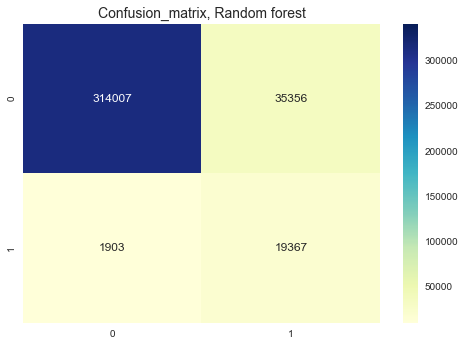

In [27]:
rf_cm = confusion_matrix(y,rf_yhat_original)
sns.heatmap(rf_cm, vmin=10000, vmax=340000, annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Confusion_matrix, Random forest', fontsize = 14)

In [28]:
tn, fp, fn, tp = rf_cm.ravel()
Recall_rf = tp / (tp + fn)
Precision_rf = tp / (tp + fp) 
print('Accuracy score on original data: ', round((tn + tp)/(tn + fp + fn + tp),3))
print('Recall:', round(Recall_rf,3))
print('Precision:', round(Precision_rf,3))

Accuracy score on original data:  0.899
Recall: 0.911
Precision: 0.354


Text(0.5, 1.0, 'Feature Importance by Feature')

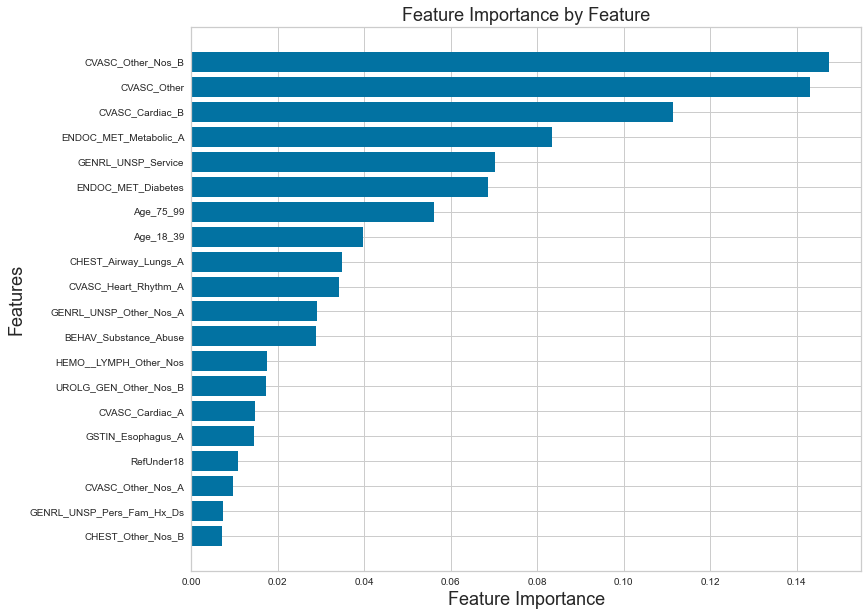

In [29]:
plt.figure(figsize=(12, 10))
plt.barh(X.columns[np.argsort(rf.best_estimator_.feature_importances_)][-20:], sorted(
    rf.best_estimator_.feature_importances_, reverse=False)[-20:])

plt.xlabel('Feature Importance', fontsize= 18)
plt.ylabel('Features', fontsize= 18)
plt.title('Feature Importance by Feature', fontsize= 18)

AUC: 0.95


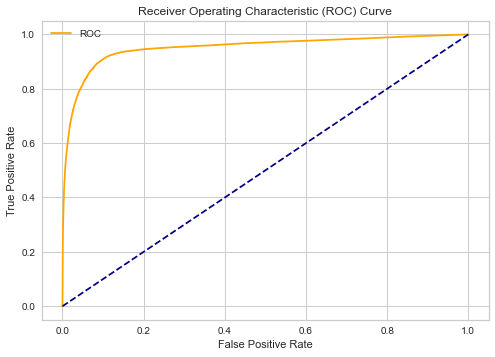

In [30]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
probs = rf.predict_proba(X)
probs = probs[:, 1]
auc = roc_auc_score(y, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y, probs)
plot_roc_curve(fpr, tpr)

## Logistic regression

In [31]:
lg_parameters = {'C': [0.01,0.1,1,10,100]}
lg = model_selection.GridSearchCV(
    LogisticRegression(max_iter = 10000, random_state = 42), lg_parameters, cv=3, return_train_score=True).fit(X_train, y_train)
lg_yhat_test = lg.predict(X_test)
lg_yhat_original = lg.predict(X)

print(lg.best_estimator_)
print('Accuracy score on testing set: ', round(metrics.accuracy_score(lg_yhat_test, y_test), 3))

LogisticRegression(C=1, max_iter=10000, random_state=42)
Accuracy score on testing set:  0.945


In [32]:
lg_df = pd.DataFrame(columns=["threshold", "accuracy",
                              "recall", "precision", "f1 score", "roc_auc_score"])
thresholds = np.arange(0.1, 1, 0.1)

for threshold in thresholds:
    preds = np.where(lg.predict_proba(X_test)[:, 1] > threshold, 1, 0)
    temp = pd.DataFrame([[threshold, accuracy_score(y_test, preds), recall_score(y_test, preds), precision_score(y_test, preds), f1_score(
        y_test, preds), roc_auc_score(y_test, preds)]], columns=["threshold", "accuracy", "recall", "precision", "f1 score", "roc_auc_score"])
    lg_df = lg_df.append(round(temp, 2))

lg_df.to_csv('logistic_threshold.csv')
lg_df

,threshold,accuracy,recall,precision,f1 score,roc_auc_score
0,0.1,0.87,0.95,0.82,0.88,0.87
0,0.2,0.91,0.95,0.89,0.92,0.91
0,0.3,0.93,0.95,0.91,0.93,0.93
0,0.4,0.94,0.95,0.93,0.94,0.94
0,0.5,0.95,0.94,0.95,0.95,0.95
0,0.6,0.95,0.94,0.96,0.95,0.95
0,0.7,0.96,0.94,0.97,0.96,0.96
0,0.8,0.95,0.92,0.98,0.95,0.95
0,0.9,0.90,0.80,1.00,0.89,0.90


Text(0.5, 1.0, 'Confusion_matrix, Logistic Regression')

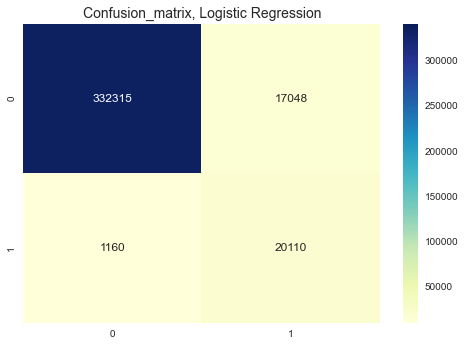

In [33]:
lg_cm = confusion_matrix(y,lg_yhat_original)
sns.heatmap(lg_cm, vmin=10000, vmax=340000, annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Confusion_matrix, Logistic Regression', fontsize = 14)

In [34]:
tn, fp, fn, tp = lg_cm.ravel()
Recall_lg = tp / (tp + fn)
Precision_lg = tp / (tp + fp) 
print('Accuracy score on original data: ', round((tn + tp)/(tn + fp + fn + tp),3))
print('Recall:', round(Recall_lg,3))
print('Precision:', round(Precision_lg,3))

Accuracy score on original data:  0.951
Recall: 0.945
Precision: 0.541


AUC: 0.97


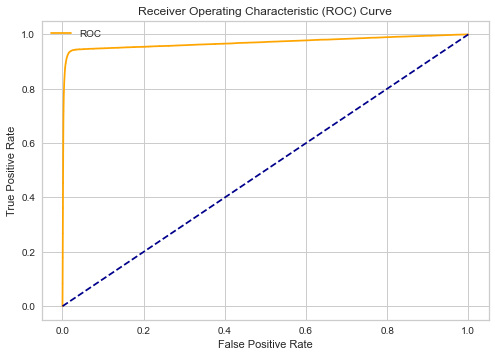

In [35]:
probs = lg.predict_proba(X)
probs = probs[:, 1]
auc = roc_auc_score(y, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y, probs)
plot_roc_curve(fpr, tpr)

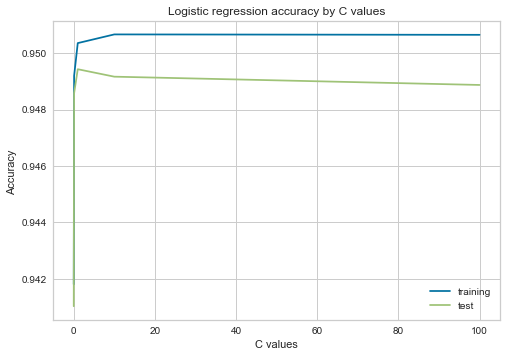

In [36]:
range_lg = [0.01,0.1,1,10,100]
result1 = pd.DataFrame(lg.cv_results_)
result1
plt.plot(range_lg,result1['mean_train_score'],label='training')
plt.plot(range_lg,result1['mean_test_score'],label='test')
plt.title('Logistic regression accuracy by C values')
plt.ylabel('Accuracy ')
plt.xlabel('C values')
plt.legend()
plt.show()

## SVC

In [66]:
svc_parameters = {'C': [0.1, 1, 10, 100]}

svc = model_selection.GridSearchCV(
    SVC(kernel='linear', random_state=42, probability=True), svc_parameters, cv=2, return_train_score=True, n_jobs=-1).fit(X_train, y_train)

svc_yhat_test = svc.predict(X_test)
svc_yhat_original = svc.predict(X)

print(svc.best_estimator_)
print('Accuracy score on testing set: ', round(
    metrics.accuracy_score(svc_yhat_test, y_test), 3))

SVC(C=10, kernel='linear', probability=True, random_state=42)
Accuracy score on testing set:  0.948


Text(0.5, 1.0, 'Confusion_matrix, SVC')

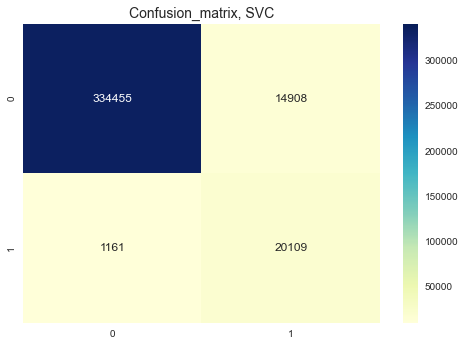

In [67]:
svc_cm = confusion_matrix(y,svc_yhat_original)
sns.heatmap(svc_cm, vmin=10000, vmax=340000, annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Confusion_matrix, SVC', fontsize = 14)

In [68]:
tn, fp, fn, tp = svc_cm.ravel()
Recall_svc = tp / (tp + fn)
Precision_svc = tp / (tp + fp) 
print('Accuracy score on original data: ', round((tn + tp)/(tn + fp + fn + tp),3))
print('Recall:', round(Recall_svc,3))
print('Precision:', round(Precision_svc,3))

Accuracy score on original data:  0.957
Recall: 0.945
Precision: 0.574


AUC: 0.97


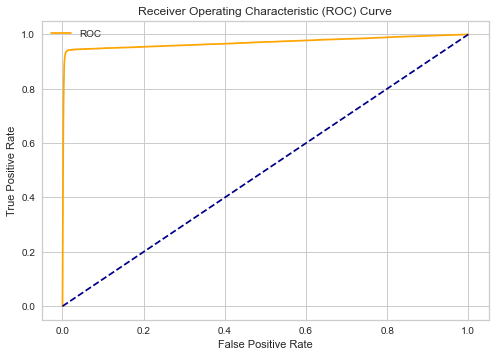

In [69]:
probs = svc.predict_proba(X)
probs = probs[:, 1]
auc = roc_auc_score(y, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y, probs)
plot_roc_curve(fpr, tpr)

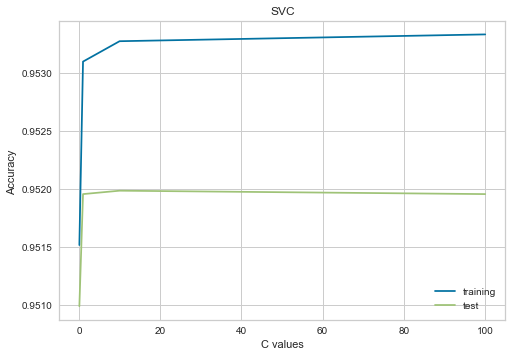

In [70]:
range_svc = [0.1,1,10,100]
result = pd.DataFrame(svc.cv_results_)
result
plt.plot(range_svc,result['mean_train_score'],label='training')
plt.plot(range_svc,result['mean_test_score'],label='test')
plt.ylabel('Accuracy ')
plt.xlabel('C values')
plt.title('SVC')
plt.legend()
plt.show()

## KNN -- PCA

In [71]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_copy = X.copy()
pca = PCA(n_components = 0.70)
pca.fit(X_train_copy)
X_train_pca = pca.transform(X_train_copy)
X_test_pca = pca.transform(X_test_copy)
X_pca = pca.transform(X_copy)

In [72]:
X_train_pca[0].shape

(20,)

In [73]:
knn_dict = {}
for k in range(2,11):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_pca, y_train)
    knn_cm = confusion_matrix(y_test, knn.predict(X_test_pca))
    tn, fp, fn, tp = knn_cm.ravel()
    Recall_knn = tp / (tp + fn)
    Precision_knn = tp / (tp + fp) 
    knn_dict[k] = [Recall_knn, Precision_knn]

In [74]:
knn_sorted = {k: v for k, v in sorted(knn_dict.items(), key=lambda item: item[1][0])}
for key in knn_sorted:
    pass
print('Best number of neighbors: ', key)

Best number of neighbors:  9


In [78]:
knn = KNeighborsClassifier(n_neighbors = key)
knn.fit(X_pca, y)
knn_cm = confusion_matrix(y, knn.predict(X_pca))
tn, fp, fn, tp = knn_cm.ravel()
Recall_knn = tp / (tp + fn)
Precision_knn = tp / (tp + fp) 
print('Recall:', round(Recall_knn,3))
print('Precision:', round(Precision_knn,3))

Recall: 0.626
Precision: 0.918


In [82]:
print('Accuracy score on original data: ', round((tn + tp)/(tn + fp + fn + tp),3))

Accuracy score on original data:  0.975


Text(0.5, 1.0, 'Confusion_matrix, KNN')

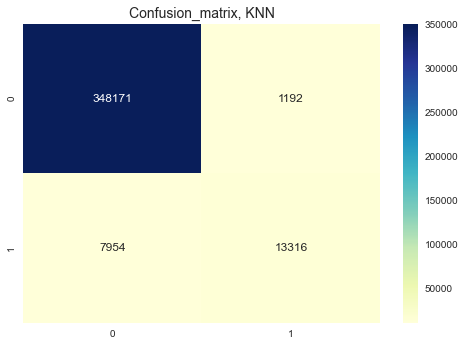

In [79]:
sns.heatmap(knn_cm, vmin=10000, vmax=350000, annot = True, fmt = 'd',cmap="YlGnBu")
plt.title('Confusion_matrix, KNN', fontsize = 14)